In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day4.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig2.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PN

In [2]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization
from tensorflow.keras import regularizers

2024-10-31 15:58:20.384268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 15:58:20.384417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 15:58:20.549727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def load_img(input_dir):
    data_dir = input_dir
    filepath = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        file_path = os.path.join(data_dir,fold)
        fpath = os.listdir(file_path)
        for f in fpath:
            fil_path = os.path.join(file_path,f)
            filepath.append(fil_path)
            labels.append(fold)
        
    F_series = pd.Series(filepath, name = "filepath")
    l_series = pd.Series(labels, name = "labels")
    
    df = pd.concat([F_series,l_series], axis = 1)
    
    return df

In [5]:
train_df = load_img("/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/")
dummy_df = load_img("/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/")

In [6]:
train_df.head()

,filepath,labels
0,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
1,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
2,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
3,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
4,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA


In [7]:
dummy_df.head()

,filepath,labels
0,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
1,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
2,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
3,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA
4,/kaggle/input/covid19-xray-dataset-train-test-...,PNEUMONIA


In [8]:
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, random_state=42, stratify = dummy_df["labels"])

In [9]:
batch_size=16
image_size=(224,224)
channels=3
image_shape=(image_size[0],image_size[1],channels)
tr_gen=ImageDataGenerator()
ts_gen=ImageDataGenerator()
train_gen=tr_gen.flow_from_dataframe(train_df,x_col="filepath",y_col="labels",target_size=image_size,
                                     class_mode="categorical",
                                    color_mode="rgb",batch_size=batch_size)
valid_gen=ts_gen.flow_from_dataframe(valid_df,x_col="filepath",y_col="labels",target_size=image_size,
                                     class_mode="categorical",
                                    color_mode="rgb",batch_size=batch_size)
test_gen=ts_gen.flow_from_dataframe(test_df,x_col="filepath",y_col="labels",target_size=image_size,
                                    class_mode="categorical",
                                    color_mode="rgb",batch_size=batch_size)

Found 148 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


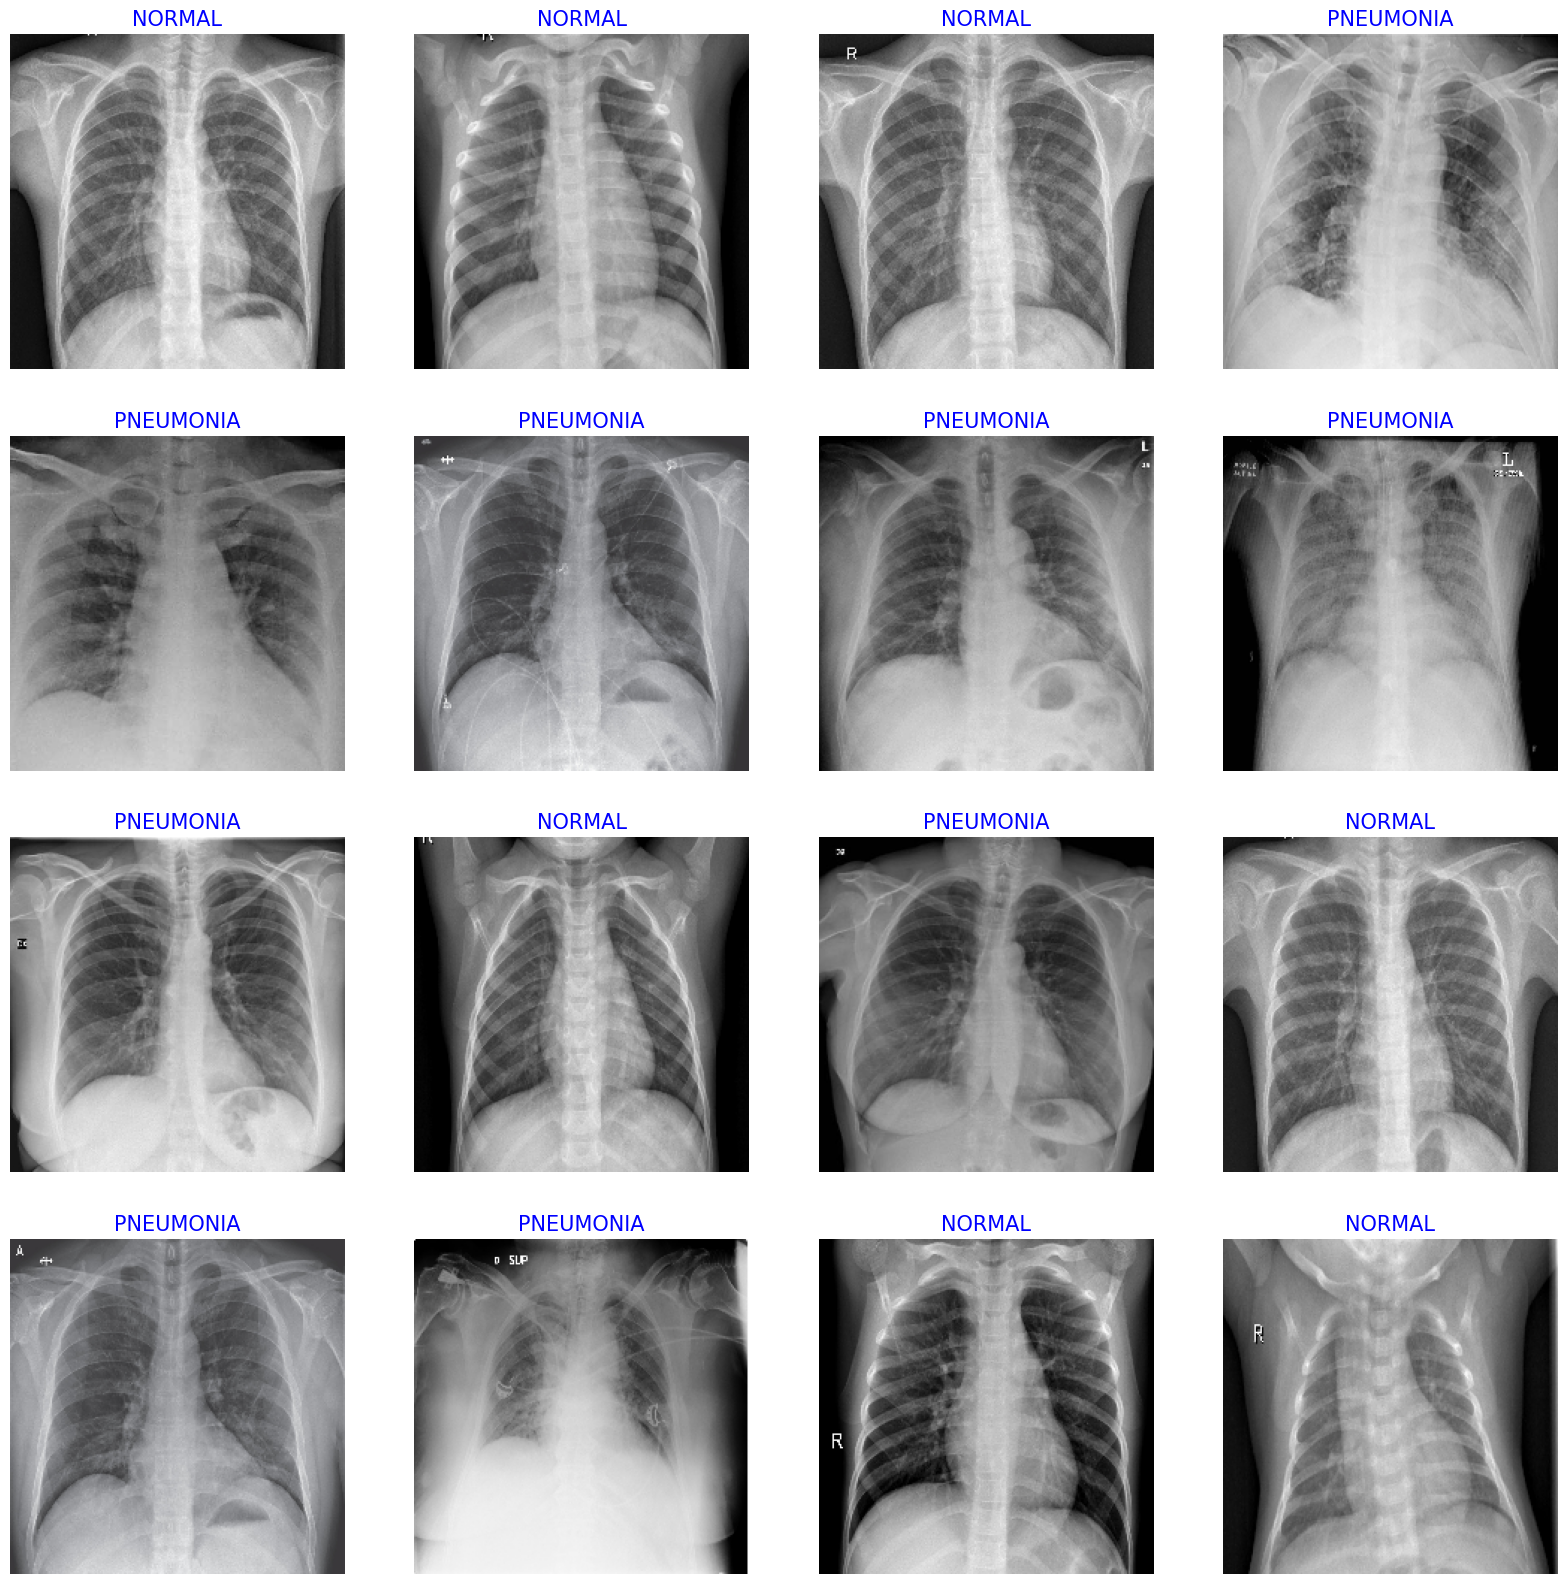

In [10]:
g_dict=train_gen.class_indices
classes=list(g_dict.keys())
images,labels=next(train_gen)
plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image=images[i]/255
    plt.imshow(image)
    index=np.argmax(labels[i])
    classes_name=classes[index]
    plt.title(classes_name,color="blue",fontsize=15)
    plt.axis('off')
    
    
plt.show()

In [11]:
model = keras.Sequential([
    Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = image_shape),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(32, kernel_size = 3, activation = 'relu', padding = 'same', input_shape = image_shape),
    BatchNormalization(),
    MaxPooling2D(2),
    
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.4),
    Dense(2, activation = 'softmax')
    
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    10,035,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,045,902 (38.32 MB)

 Trainable params: 10,045,774 (38.32 MB)

 Non-trainable params: 128 (512.00 B)

In [12]:
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, epochs= 5, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7243 - loss: 1.7506 - val_accuracy: 0.8000 - val_loss: 2.4878
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8990 - loss: 0.4209 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.9582 - loss: 0.1118 - val_accuracy: 0.9000 - val_loss: 0.4812
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9912 - loss: 0.0227 - val_accuracy: 0.8000 - val_loss: 0.7253
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9974 - loss: 0.0177 - val_accuracy: 0.8500 - val_loss: 0.4999


In [13]:
model.evaluate(test_gen)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8042 - loss: 1.6386 


[2.050295829772949, 0.800000011920929]